In [1]:
import os
import re

from astroquery.mast import Observations
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.table import Table, join, vstack
import astropy.units as u
from astropy.wcs import WCS
import numpy as np
import pandas as pd

from tqdm.notebook import trange


In [2]:
# Only need to do this once to clean up masterlens
# import pandas as pd
# df = pd.read_csv('slacs_catalog.csv')
# for key in df:
#     if 'system_name' not in key:
#         df.rename(columns={key: key[2:-1]}, inplace=True)
#     else:
#         df.rename(columns={key: key[1:-1]}, inplace=True)
# df.to_csv('slacs_catalog.csv', index=False)

lens_table = Table.read('slacs_catalog.csv')

In [3]:
CUTOUT_SIZE = 128
all_obs_table = None

for i in trange(2):#len(table)):
    # Get coordinates of lens.
    coord = SkyCoord(
        lens_table['ra_coord'][i], lens_table['dec_coord'][i],
        unit=(u.deg, u.deg)
    )
    system_name = lens_table['system_name'][i].replace(' ','_')

    # Search for observations in near the coordinates.
    obs_table = Observations.query_region(coord, radius=0.01*u.deg)

    # Filter for HST, ACS/WFC, and F814W filter. This should narrow it down to
    # the slacs observations. Should have SLACS-length exposure as well.
    obs_table = obs_table[
        (obs_table['obs_collection'] == 'HST')
        & (obs_table['instrument_name'] == 'ACS/WFC')
        & (obs_table['filters'] == 'F814W')
        & (obs_table['provenance_name'] == 'CALACS')
    ]

    # Deal with too many or not enough observations.
    if len(obs_table) == 0:
        print(
            f'Lens {system_name} at {coord.ra}, {coord.dec} has no'
            f'relevant observations.'
        )
        continue
    elif len(obs_table) > 1:
        print(
            f'Lens {system_name} at {coord.ra}, {coord.dec} has more'
            f'than one relevant observations. Using the max exposure time.'
        )
        obs_table = obs_table[np.argmax(obs_table['t_exptime'])]

    # Add the system name to the observation table.
    obs_table['system_name'] = lens_table['system_name'][i]

    # Make a target directory if required.
    target_dir = system_name
    if not os.path.exists(target_dir):
            os.makedirs(target_dir)

    # Download the file
    local_path = os.path.join(target_dir, 'calacs.fits')
    _ = Observations.download_file(
        uri=obs_table["dataURL"][0],
        local_path=local_path
    )
    obs_table['full_field_filepath'] = local_path

    # Open the fits file and get the cutout
    with fits.open(local_path) as hdu:
        data_header = hdu[1].header
        data = hdu[1].data
        wcs = WCS(data_header, hdu)
    cutout = Cutout2D(
        data, coord, size = (CUTOUT_SIZE, CUTOUT_SIZE), wcs = wcs,
        mode = 'partial'
    ).data

    # Save the cutout to the table.
    obs_table['image'] = [cutout]

    # Append to larger table.
    if all_obs_table is None:
        all_obs_table = obs_table
    else:
        all_obs_table = vstack([all_obs_table, obs_table], join_type='exact')

# Finally join it all together and save.
full_table = join(lens_table, obs_table, keys='system_name', join_type='outer')

# Save table as a FITS file
full_table.write('test.fits', format='fits', overwrite=True)

  0%|          | 0/2 [00:00<?, ?it/s]

INFO: Found cached file SDSS_J0008-0004/calacs.fits with expected size 214911360. [astroquery.query]
INFO: Found cached file SDSS_J0029-0055/calacs.fits with expected size 214971840. [astroquery.query]


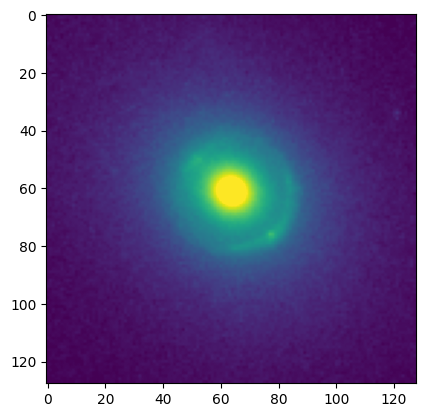

In [5]:
from astropy.visualization import simple_norm
import matplotlib.pyplot as plt
cutout = Table.read('test.fits')['image'][1]
norm = simple_norm(cutout, stretch='asinh', asinh_a=0.1, percent=99.0)
plt.imshow(cutout, norm=norm)